In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# min-max scaler
from sklearn.preprocessing import MinMaxScaler

# recursive feature elimination
from sklearn.feature_selection import RFE

# estimators
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

agg = pd.DataFrame({'actual':elec.sum(axis=1)})

In [3]:
# add lag features
for i in [1,2,3,24,25,26,48,49,50]:
    agg['t-'+str(i)] = np.append(np.array([np.nan]*i),agg['actual'][0:len(agg)-i])
    
# add day of week features
days = ['mon','tues','wed','thurs','fri','sat','sun']
for i in range(7):
    agg[days[i]] = (np.array([i]*len(agg))==np.asarray(agg.index.dayofweek)).astype(int)
    
# add hour of day features
for i in range(12):
    agg[str(i)+'am'] = (np.array([i]*len(agg))==np.asarray(agg.index.hour)).astype(int)
for i in range(12,24):
    agg[str(i-12)+'pm'] = (np.array([i]*len(agg))==np.asarray(agg.index.hour)).astype(int)
agg = agg.rename({'0am':'12am','0pm':'12pm'},axis=1)

# feature for school breaks
agg['break'] = (agg.index.isin(pd.date_range(start='01/01/2018', end='01/15/2018', freq='H',closed='left'))
                | agg.index.isin(pd.date_range(start='03/10/2018', end='03/25/2018', freq='H',closed='left'))
                | agg.index.isin(pd.date_range(start='05/10/2018', end='08/22/2018', freq='H',closed='left'))
               ).astype(int)

# feature for office holidays: MLK day, memorial day, 4th of july
agg['holiday'] = (agg.index.isin(pd.date_range(start='01/15/2018', end='01/16/2018', freq='H',closed='left'))
                  | agg.index.isin(pd.date_range(start='05/28/2018', end='05/29/2018', freq='H',closed='left'))
                  | agg.index.isin(pd.date_range(start='07/04/2018', end='07/05/2018', freq='H',closed='left'))
                 ).astype(int)

# trim NaNs from lag calculation
data = agg['2018-01-04 00:00:00':]

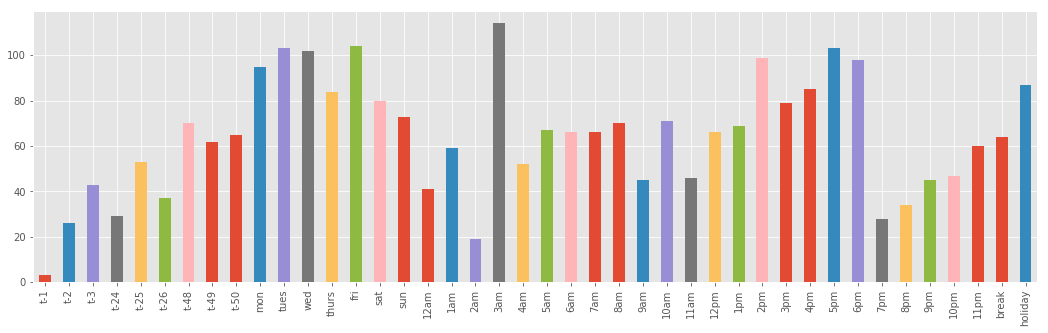

In [4]:
X = data.loc[:,'t-1':].values
y = data.loc[:,'actual'].values.reshape(-1, 1)

X_scaler = MinMaxScaler().fit(X)
y_scaler = MinMaxScaler().fit(y)

X_rfe = X_scaler.transform(X)
y_rfe = y_scaler.transform(y).ravel()

model_names = ['Linear Regression','Support Vector Regression','Decision Tree Regression']
models = [LinearRegression(),SVR(kernel='linear'),DecisionTreeRegressor()]
results = pd.DataFrame(index=data.loc[:,'t-1':].columns)

for i in range(len(models)):
    rfe = RFE(models[i], 1)
    rfe = rfe.fit(X_rfe, y_rfe)
    results[model_names[i]] = rfe.ranking_
    
results['Cumulative Score'] = results.sum(axis=1)
results['Cumulative Score'].plot(kind='bar',figsize=(18,5))